<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

In [2]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [3]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [4]:
from google.colab import drive

drive._mount('/content/gdrive')

Mounted at /content/gdrive


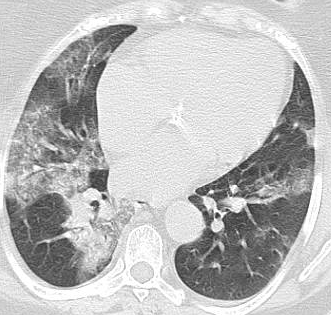

In [5]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [6]:
path = Path(f"{dataset_path}")

In [7]:
imgs = get_image_files(f"{dataset_path}")
imgs

(#2481) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1233).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1205).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1220).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1216).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1223).png')...]

In [8]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

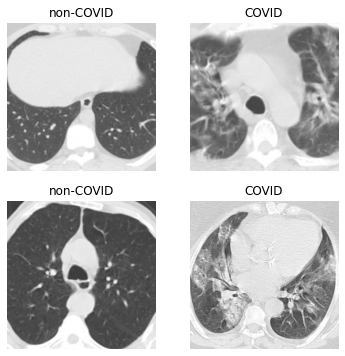

In [9]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [10]:
dls.train.vocab

['non-COVID', 'COVID']

In [11]:
res34 = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
lr = 1e-3
res34.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.970175,0.479959,0.783333,0.773663,02:57
1,0.659488,0.315607,0.861598,0.909465,00:43


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.340374,0.166633,0.919831,0.897119,00:59
1,0.212853,0.136593,0.950617,0.950617,00:57
2,0.134348,0.085333,0.971311,0.975309,00:57
3,0.091736,0.088200,0.967213,0.971193,00:57


In [13]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [14]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.340374,0.166633,0.919831,0.897119
1,0.212853,0.136593,0.950617,0.950617
2,0.134348,0.085333,0.971311,0.975309
3,0.091736,0.088200,0.967213,0.971193


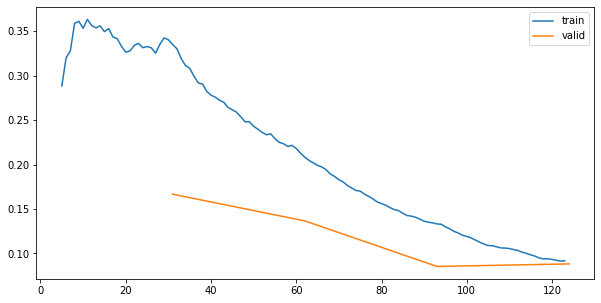

In [15]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

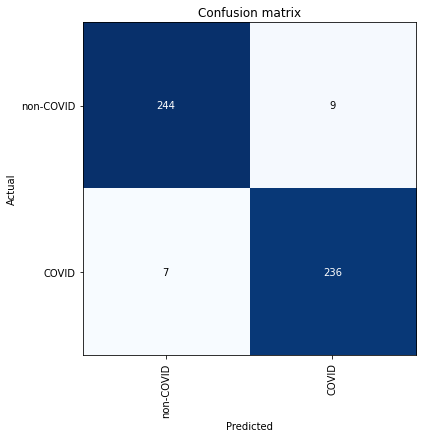

In [16]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

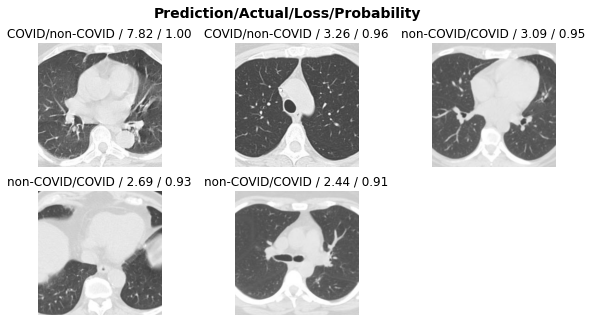

In [17]:
interp.plot_top_losses(5, figsize=(10,5))

In [18]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([1.9366e-05, 9.9998e-01]))

In [19]:
res34.export('res34.pkl')

In [20]:
"""
del res34
gc.collect()
torch.cuda.empty_cache()
"""

'\ndel res34\ngc.collect()\ntorch.cuda.empty_cache()\n'

In [21]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, Contrast(p=1, draw=1.50)])
dls = covid.dataloaders(path)

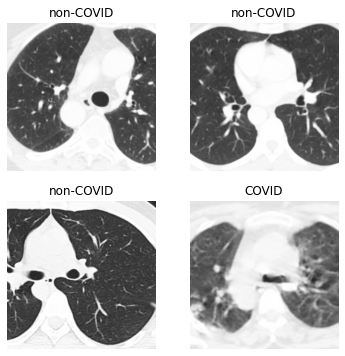

In [22]:
dls.train.show_batch(max_n=4)

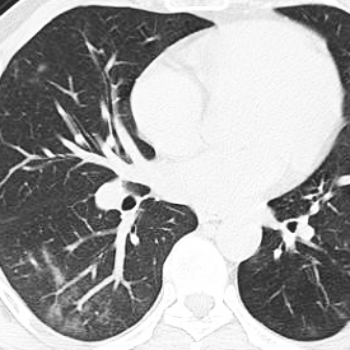

In [23]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [24]:
res34_con = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [25]:
lr = 1e-3
res34_con.fine_tune(5, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.798016,0.552082,0.771481,0.868313,00:46


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.411608,0.447990,0.821168,0.925926,00:59
1,0.278647,0.288940,0.895582,0.917695,00:59
2,0.186747,0.181939,0.925311,0.917695,00:59
3,0.127139,0.154419,0.940937,0.950617,00:59
4,0.096769,0.163532,0.943548,0.962963,00:59


In [26]:
df_rec34_con = pd.DataFrame(res34_con.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [27]:
df_rec34_con

,train_loss,valid_loss,f1_score,recall_score
0,0.411608,0.447990,0.821168,0.925926
1,0.278647,0.288940,0.895582,0.917695
2,0.186747,0.181939,0.925311,0.917695
3,0.127139,0.154419,0.940937,0.950617
4,0.096769,0.163532,0.943548,0.962963


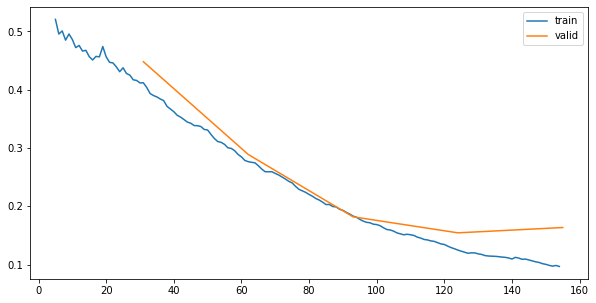

In [28]:
plt.figure(figsize=(10,5))
res34_con.recorder.plot_loss()

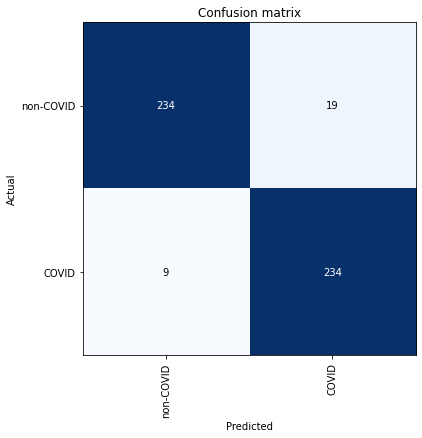

In [29]:
interp = ClassificationInterpretation.from_learner(res34_con)
interp.plot_confusion_matrix(figsize=(6,6))

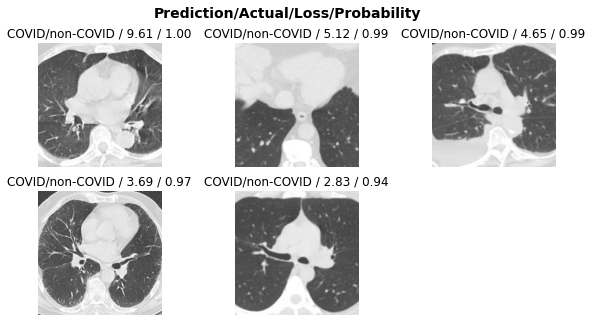

In [30]:
interp.plot_top_losses(5, figsize=(10,5))

In [31]:
res34_con.export('res34_con.pkl')

In [32]:
"""
del res34_con
gc.collect()
torch.cuda.empty_cache()
"""

'\ndel res34_con\ngc.collect()\ntorch.cuda.empty_cache()\n'

In [33]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, RandomErasing(1, min_aspect=0.3, sh=0.1)])
dls = covid.dataloaders(path)

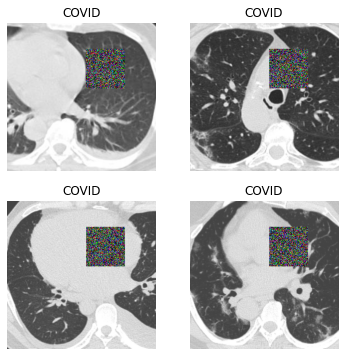

In [34]:
dls.train.show_batch(max_n=4)

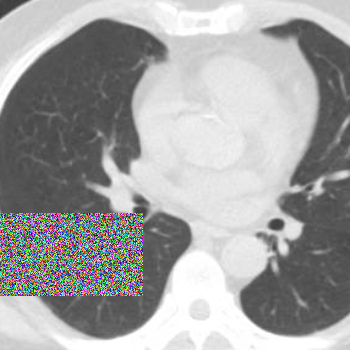

In [35]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [36]:
res34_noise = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [37]:
lr = 1e-3
res34_noise.fine_tune(6, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.985725,0.488524,0.794643,0.732510,00:45
1,0.727822,0.359522,0.853846,0.913580,00:45


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.447310,0.276762,0.897704,0.884774,00:59
1,0.348936,0.168277,0.934461,0.909465,00:59
2,0.266552,0.132248,0.955975,0.938272,00:59
3,0.204350,0.086354,0.969325,0.975309,00:59
4,0.155434,0.078394,0.970833,0.958848,00:59
5,0.121100,0.072581,0.975104,0.967078,00:59


In [38]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [39]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.447310,0.276762,0.897704,0.884774
1,0.348936,0.168277,0.934461,0.909465
2,0.266552,0.132248,0.955975,0.938272
3,0.204350,0.086354,0.969325,0.975309
4,0.155434,0.078394,0.970833,0.958848
5,0.121100,0.072581,0.975104,0.967078


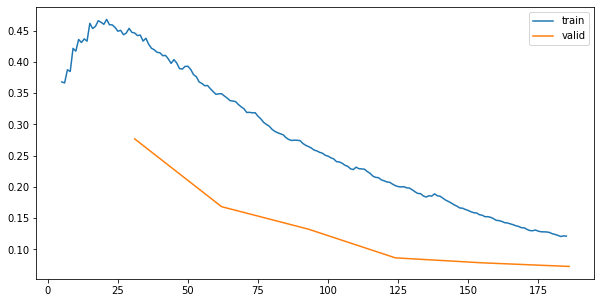

In [40]:
plt.figure(figsize=(10,5))
res34_noise.recorder.plot_loss()

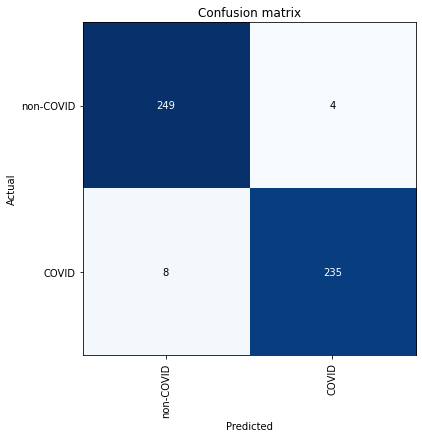

In [41]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

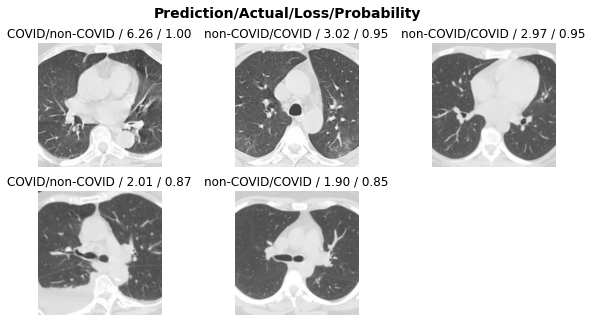

In [42]:
interp.plot_top_losses(5, figsize=(10,5))

In [43]:
res34_noise.export('res34_noise.pkl')

In [44]:
"""
del res34_noise
gc.collect()
torch.cuda.empty_cache()
"""

'\ndel res34_noise\ngc.collect()\ntorch.cuda.empty_cache()\n'

## Inference

Load the model from URL

In [45]:
"""
res34 = load_learner(f'{folder_path}res34.pkl')
res34_con = load_learner(f'{folder_path}res34_con.pkl')
res34_noise = load_learner(f'{folder_path}res34_noise.pkl')
"""

"\nres34 = load_learner(f'{folder_path}res34.pkl')\nres34_con = load_learner(f'{folder_path}res34_con.pkl')\nres34_noise = load_learner(f'{folder_path}res34_noise.pkl')\n"

In [46]:
class Ensemble:
  def __init__(self, dl, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for name, model in self.models.items():
      print(f'Getting predictions from {name}')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = {}
    _,_, targs, decoded,_ = self.get_preds(self.dl)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res

In [47]:
en = Ensemble(dls.valid, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=['non-covid', 'covid'])
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-covid', 'covid']
loaded: res34
loaded: res34_con
loaded: res34_noise


In [48]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('non-covid',
 array([0.6631395 , 0.33686045], dtype=float32),
 array([0.42749226, 0.42749223], dtype=float32))

In [49]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.0592, 0.9408]))

In [50]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

In [51]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

{'F1Score': 0.9793388429752067, 'Recall': 0.9753086419753086}

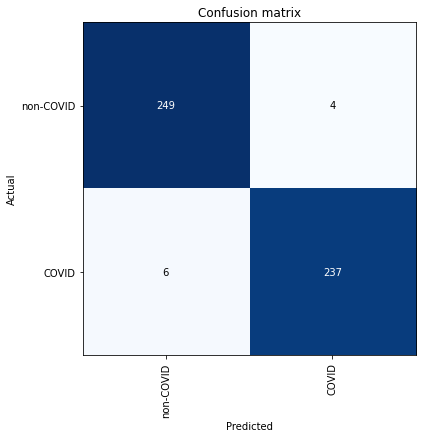

In [52]:
# interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) -> calls get_preds
interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

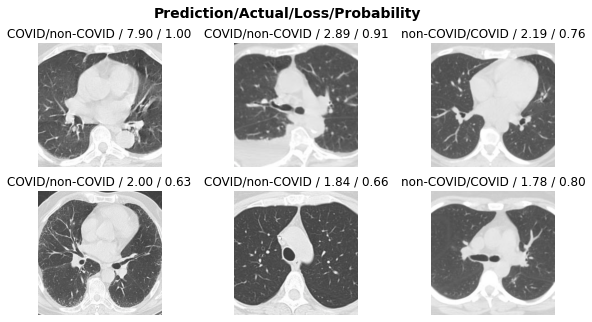

In [53]:
interp.plot_top_losses(6, figsize=(10,5))